In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
%matplotlib inline
import textwrap # for wrapping answer descriptions
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
import scrubbington as scrub
import evaluationton as evalu
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_json('../data/data.json')

In [3]:
from scrubbington import scrub_everything

In [4]:
feature_names = ['channels', 'fb_published', 'has_analytics', 'has_logo', 'num_order', 'num_payouts',
'sale_duration2', 'show_map', 'user_age', 'user_type', 'body_length']

In [5]:
df_test, y, X = scrub_everything(df, feature_names)
X

array([[    5,     0,     0, ...,    36,     1,  3852],
       [    0,     0,     0, ...,   149,     3,  3499],
       [    8,     0,     0, ...,   214,     3,  2601],
       ...,
       [   13,     1,     0, ...,    84,     4,   557],
       [    8,     0,     0, ...,   812,     3, 10873],
       [    0,     0,     0, ...,     0,     1,     0]])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
X_train_len = X_train.shape[0]
X_test_len = X_test.shape[0]

y_train_len = y_train.shape[0]
y_test_len = y_test.shape[0]

print("X_train Data Count: {}".format(X_train_len))
print("y_train Data Count: {}".format(y_train_len))
print("X_test Data Count: {}".format(X_test_len))
print("y_test Data Count: {}".format(y_test_len))

print("\n\nSplit Percentage for Train Data: {}".format(X_train_len/(X_train_len + X_test_len)))

X_train Data Count: 10752
y_train Data Count: 10752
X_test Data Count: 3585
y_test Data Count: 3585


Split Percentage for Train Data: 0.7499476878007951


# AdaBoost

In [8]:
abc = AdaBoostClassifier(n_estimators=50)
abc.fit(X_train, y_train)

print("sklearn ABC accuracy: {0:0.3f}".format(abc.score(X_test, y_test)))

sklearn ABC accuracy: 0.959


In [9]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    abc = AdaBoostClassifier(n_estimators=20, learning_rate = learning_rate, random_state = 0)
    abc.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(abc.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(abc.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.917
Accuracy score (validation): 0.912
Learning rate:  0.1
Accuracy score (training): 0.918
Accuracy score (validation): 0.914
Learning rate:  0.25
Accuracy score (training): 0.954
Accuracy score (validation): 0.952
Learning rate:  0.5
Accuracy score (training): 0.958
Accuracy score (validation): 0.958
Learning rate:  0.75
Accuracy score (training): 0.959
Accuracy score (validation): 0.961
Learning rate:  1
Accuracy score (training): 0.956
Accuracy score (validation): 0.955


#### Learning rate 0.5 is chosen 

In [10]:
abc = AdaBoostClassifier(n_estimators=20, learning_rate = 0.5, random_state = 0)
abc.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=20, random_state=0)

### Confusion Matrix

In [11]:
y_predictions = abc.predict(X_test)

In [12]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predictions).ravel()

In [13]:
print("True Negative: {}".format(tn))
print("True Positive: {}".format(tp))
print("False Negative: {}".format(fn))
print("False Positive: {}".format(fp))

True Negative: 3203
True Positive: 231
False Negative: 100
False Positive: 51


### Plotting Methods

In [14]:
def plot_roc(y_test, X_test, model, model_name):
    AUC = roc_auc_score(y_test, abc.predict_proba(X_test)[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, abc.predict_proba(X_test)[:,1])
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(model_name))
    plt.legend(loc="lower right");

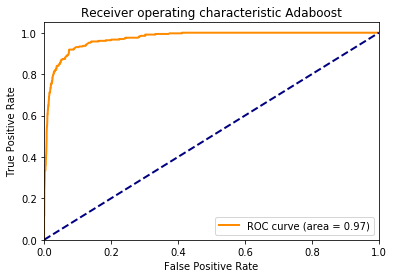

In [15]:
plot_roc(y_test, X_test, model=abc, model_name='Adaboost')

### Using Evaluationton

In [16]:
scoring = evalu.Scores(model=abc, X_test=X_test, y_test=y_test)
scoring.scores()

Accuracy: 0.9578800557880056
Precision 0.8191489361702128
Recall 0.6978851963746223
F1 0.7536704730831973


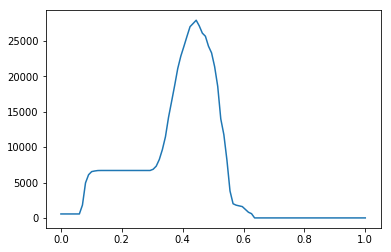

In [17]:
false_pos = -10
true_pos  = 100
false_neg = 0
true_neg  = 0

profit_matrix = [[true_neg, false_pos],[false_neg, true_pos]]
x_threshold, y_profit = scoring.profit_curve(num_points=100, profit_matrix=profit_matrix)

fig, ax = plt.subplots()
ax.plot(x_threshold, y_profit);